In [1]:
article_list = []

for i in range(1, 511):
    if i < 10:
        i = '00' + str(i)
    elif i > 9 and i < 100:
        i = '0' + str(i)
    else:
        i = str(i)
        
    news_article = 'BBC_News_Summary/News_Articles/business/' + i + '.txt'
    news = ''
    with open(news_article) as f:
        for line in f.readlines():
            line = line.strip()
            news += line
            news += " "
        article_list.append(news)

In [2]:
summary_list = []

for i in range(1, 511):
    if i < 10:
        i = '00' + str(i)
    elif i > 9 and i < 100:
        i = '0' + str(i)
    else:
        i = str(i)
        
    news_article_summary = 'BBC_News_Summary/Summaries/business/' + i + '.txt'
    summary = '_START_ '
    
    with open(news_article_summary) as f:
        for line in f.readlines():
            line = line.strip()
            summary += line
            summary += " "
        summary = summary + " _END_"
        summary_list.append(summary)

In [3]:
import pandas as pd

df = pd.DataFrame(columns = ['article', 'summary'])

for i in range(len(article_list)):
    row = pd.Series({'article' : article_list[i], 'summary' : summary_list[i]})
    df = pd.concat([df, row.to_frame().T], ignore_index = True)
    
df.head()

,article,summary
0,Ad sales boost Time Warner profit Quarterly p...,_START_ TimeWarner said fourth quarter sales r...
1,Dollar gains on Greenspan speech The dollar h...,_START_ The dollar has hit its highest level a...
2,Yukos unit buyer faces loan claim The owners ...,_START_ Yukos' owner Menatep Group says it wil...
3,High fuel prices hit BA's profits British Air...,"_START_ Rod Eddington, BA's chief executive, s..."
4,Pernod takeover talk lifts Domecq Shares in U...,_START_ Pernod has reduced the debt it took on...


In [4]:
from sklearn.model_selection import train_test_split
article_tr, article_val, summary_tr, summary_val=train_test_split(df['article'],
                                                                   df['summary'],
                                                                   test_size=0.1,
                                                                   random_state=0,
                                                                   shuffle=True) 

In [5]:
max_length = 0
articles = list(df['article'])

for article in articles:
    if len(article.split()) > max_length:
        max_length = len(article.split())
    else:
        continue

print(max_length)

891


In [6]:
max_length = 0
summaries = list(df['summary'])

for summary in summaries:
    if len(summary.split()) > max_length:
        max_length = len(summary.split())
    else:
        continue

print(max_length)

405


In [7]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(list(df['article']))

article_tr = article_tokenizer.texts_to_sequences(article_tr) 
article_val = article_tokenizer.texts_to_sequences(article_val) 

article_tr = pad_sequences(article_tr,  maxlen = 800, padding='post') 
article_val = pad_sequences(article_val, maxlen = 800, padding='post')

article_voc_size = len(article_tokenizer.word_index) +1

print(article_voc_size)

12675


In [8]:
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(list(df['summary']))

summary_tr = summary_tokenizer.texts_to_sequences(summary_tr) 
summary_val = summary_tokenizer.texts_to_sequences(summary_val) 

summary_tr = pad_sequences(summary_tr,  maxlen = 350, padding='post') 
summary_val = pad_sequences(summary_val, maxlen = 350, padding='post')

summary_voc_size = len(summary_tokenizer.word_index) +1

print(summary_voc_size)

8202


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.layers import Concatenate, TimeDistributed

In [118]:
embedding_inputs = Input(shape=(800), name = 'Encoder_Input') #max length of article
embedding = Embedding(12675, 3, trainable=True, name = 'Encoder_Embedding')(embedding_inputs) #vocab_size_article, neurons

encoder_layer_1 = LSTM(32, return_sequences=True, return_state=True, name = 'LSTM_1') #neurons 
encoder_output_1, state_h1, state_c1 = encoder_layer_1(embedding)

encoder_layer_2 = LSTM(32, return_sequences=True, return_state=True, name = 'LSTM_2') #neurons 
encoder_output_2, state_h2, state_c2 = encoder_layer_2(encoder_output_1)

encoder_layer_3 = LSTM(32, return_sequences=True, return_state=True, name = 'LSTM_3') #neurons 
encoder_output_3, state_h3, state_c3 = encoder_layer_3(encoder_output_2)


decoder_inputs = Input(shape=(None,), name = 'Decoder_Input')
decoder_embedding_layer = Embedding(8202, 50, trainable=True, name = 'Decoder_Embedding')#vocab_size_summary, neurons
decoder_embedding = decoder_embedding_layer(decoder_inputs) 

decoder_layer_1 = LSTM(32, return_sequences = True, return_state = True, name = 'Decoder_LSTM')
decoder_output_1, decoder_state_h1, decoder_state_c1 = decoder_layer_1(decoder_embedding, 
                                                                       initial_state=[state_h3, state_c3])

decoder_dense = TimeDistributed(Dense(8202, activation = 'softmax'))#vocab_size_summary
decoder_outputs = decoder_dense(decoder_output_1)

model = Model([embedding_inputs, decoder_inputs], decoder_outputs)

In [119]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [12]:
summary_tr[:, :-1]

array([[  16,    1, 1227, ...,    0,    0,    0],
       [  16,   21,    1, ...,    0,    0,    0],
       [  16, 1936,  286, ...,    0,    0,    0],
       ...,
       [  16,    8,    1, ...,    0,    0,    0],
       [  16,    1,  514, ...,    0,    0,    0],
       [  16, 1986,    6, ...,    0,    0,    0]], dtype=int32)

In [13]:
summary_tr.shape[0]

459

In [14]:
summary_tr.shape[1]

350

In [120]:
history = model.fit([article_tr, summary_tr[:,:-1]], 
                    summary_tr.reshape(summary_tr.shape[0], summary_tr.shape[1], 1)[:,1:],
                    epochs=200,
                    validation_split = 0.2,
                    batch_size=32,
                    verbose = 1)

Epoch 1/200
12/12 [==============================] - 16s 1s/step - loss: 8.7587 - val_loss: 8.1126
Epoch 2/200
12/12 [==============================] - 12s 972ms/step - loss: 7.7452 - val_loss: 7.3418
Epoch 3/200
12/12 [==============================] - 13s 1s/step - loss: 7.0530 - val_loss: 6.7282
Epoch 4/200
12/12 [==============================] - 13s 1s/step - loss: 6.4662 - val_loss: 6.1843
Epoch 5/200
12/12 [==============================] - 13s 1s/step - loss: 5.9412 - val_loss: 5.6878
Epoch 6/200
12/12 [==============================] - 15s 1s/step - loss: 5.4639 - val_loss: 5.2406
Epoch 7/200
12/12 [==============================] - 14s 1s/step - loss: 5.0328 - val_loss: 4.8342
Epoch 8/200
12/12 [==============================] - 14s 1s/step - loss: 4.6429 - val_loss: 4.4714
Epoch 9/200
12/12 [==============================] - 12s 996ms/step - loss: 4.2992 - val_loss: 4.1637
Epoch 10/200
12/12 [==============================] - 14s 1s/step - loss: 4.0225 - val_loss: 3.9349
Epo

Epoch 83/200
12/12 [==============================] - 13s 1s/step - loss: 2.6239 - val_loss: 3.0527
Epoch 84/200
12/12 [==============================] - 13s 1s/step - loss: 2.6185 - val_loss: 3.0523
Epoch 85/200
12/12 [==============================] - 14s 1s/step - loss: 2.6134 - val_loss: 3.0532
Epoch 86/200
12/12 [==============================] - 12s 1s/step - loss: 2.6092 - val_loss: 3.0510
Epoch 87/200
12/12 [==============================] - 13s 1s/step - loss: 2.6042 - val_loss: 3.0560
Epoch 88/200
12/12 [==============================] - 14s 1s/step - loss: 2.6011 - val_loss: 3.0514
Epoch 89/200
12/12 [==============================] - 13s 1s/step - loss: 2.5942 - val_loss: 3.0522
Epoch 90/200
12/12 [==============================] - 12s 1s/step - loss: 2.5914 - val_loss: 3.0498
Epoch 91/200
12/12 [==============================] - 13s 1s/step - loss: 2.5869 - val_loss: 3.0483
Epoch 92/200
12/12 [==============================] - 13s 1s/step - loss: 2.5806 - val_loss: 3.0500


12/12 [==============================] - 13s 1s/step - loss: 2.2812 - val_loss: 3.0742
Epoch 165/200
12/12 [==============================] - 14s 1s/step - loss: 2.2787 - val_loss: 3.0747
Epoch 166/200
12/12 [==============================] - 13s 1s/step - loss: 2.2736 - val_loss: 3.0739
Epoch 167/200
12/12 [==============================] - 13s 1s/step - loss: 2.2700 - val_loss: 3.0745
Epoch 168/200
12/12 [==============================] - 13s 1s/step - loss: 2.2667 - val_loss: 3.0810
Epoch 169/200
12/12 [==============================] - 14s 1s/step - loss: 2.2632 - val_loss: 3.0758
Epoch 170/200
12/12 [==============================] - 14s 1s/step - loss: 2.2593 - val_loss: 3.0781
Epoch 171/200
12/12 [==============================] - 13s 1s/step - loss: 2.2556 - val_loss: 3.0801
Epoch 172/200
12/12 [==============================] - 13s 1s/step - loss: 2.2526 - val_loss: 3.0795
Epoch 173/200
12/12 [==============================] - 13s 1s/step - loss: 2.2485 - val_loss: 3.0795
Epoc

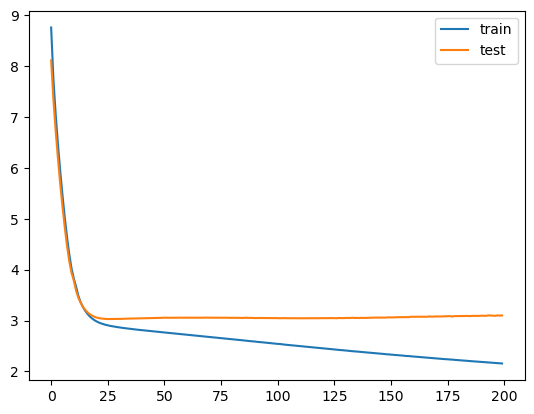

In [121]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [122]:
reverse_target_word_index = summary_tokenizer.index_word 
reverse_source_word_index = article_tokenizer.index_word 
target_word_index = summary_tokenizer.word_index

In [123]:
encoder_model = Model(inputs=embedding_inputs, outputs=[encoder_output_3, state_h3, state_c3])

decoder_state_input_h = Input(shape=(32,))
decoder_state_input_c = Input(shape=(32,))
decoder_hidden_state_input = Input(shape=(800, 32))

dec_emb2 = decoder_embedding_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_layer_1(dec_emb2, 
                                                       initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    inputs = [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    outputs = [decoder_outputs2] + [state_h2, state_c2])

In [125]:
e_out, e_h, e_c = encoder_model.predict(article_tr[5].reshape(1, 800))
output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

1/1 [==============================] - 0s 8ms/step


In [126]:
e_out

array([[[ 4.72192513e-03, -2.65722983e-02,  4.68563521e-03, ...,
          9.72672552e-03, -3.48326676e-02,  5.18781971e-03],
        [ 5.04894741e-03, -6.14997223e-02, -1.00747729e-03, ...,
          2.64351983e-02, -9.26559344e-02,  3.33030485e-02],
        [ 6.92221220e-04, -1.11993216e-01, -2.29806434e-02, ...,
          5.50499111e-02, -2.06687719e-01,  9.82135460e-02],
        ...,
        [-1.97674875e-04, -1.08240247e-02, -9.70864177e-01, ...,
          5.14688551e-01, -9.99468744e-01,  9.95865464e-01],
        [-1.97674875e-04, -1.08240098e-02, -9.70864177e-01, ...,
          5.14688730e-01, -9.99468744e-01,  9.95865464e-01],
        [-1.97675472e-04, -1.08240042e-02, -9.70864236e-01, ...,
          5.14688969e-01, -9.99468744e-01,  9.95865643e-01]]],
      dtype=float32)

In [127]:
output_tokens

array([[[1.3276100e-07, 2.7229390e-01, 1.1834061e-03, ...,
         1.2312859e-07, 6.4808391e-06, 2.1447604e-09]]], dtype=float32)

In [128]:
target_seq = np.zeros((1,1))
print(target_seq)
target_seq[0, 0] = target_word_index['start']
print(target_seq)

print(output_tokens)
sampled_token_index = np.argmax(output_tokens[0, -1, :])
reverse_target_word_index[sampled_token_index]

[[0.]]
[[16.]]
[[[1.3276100e-07 2.7229390e-01 1.1834061e-03 ... 1.2312859e-07
   6.4808391e-06 2.1447604e-09]]]


'the'

In [129]:
output_tokens[0, -1, :].shape

(8202,)

In [130]:
sample_array = np.array([1, 0, 3, 4])
sample_array.shape
np.argmax(sample_array)

3

In [131]:
import numpy as np

def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    
    decoded_sentence = ''
    
    while not stop_condition:
        print([target_seq])
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (350-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [132]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:      
        if((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i]+' '
            
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString = newString + reverse_source_word_index[i]+' '
    return newString

In [133]:
print(article_list[4])

Pernod takeover talk lifts Domecq  Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.  Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Allied Domecq shares in London rose 4% by 1200 GMT, while Pernod shares in Paris slipped 1.2%. Pernod said it was seeking acquisitions but refused to comment on specifics.  Pernod's last major purchase was a third of US giant Seagram in 2000, the move which propelled it into the global top three of drinks firms. The other two-thirds of Seagram was bought by market leader Diageo. In terms of market value, Pernod - at 7.5bn euros ($9.7bn) - is about 9% smaller than Allied Domecq, which has a capitalisation of £5.7bn ($10.7bn; 8.2bn euros). Last year Pernod tried to buy Glenmorangie, one of Scotland's premier whisky firms, but lost out to luxury goods firm LVMH

In [134]:
print(summary_list[4])

_START_ Pernod has reduced the debt it took on to fund the Seagram purchase to just 1.8bn euros, while Allied has improved the performance of its fast-food chains.Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.Pernod said it was seeking acquisitions but refused to comment on specifics.In terms of market value, Pernod - at 7.5bn euros ($9.7bn) - is about 9% smaller than Allied Domecq, which has a capitalisation of £5.7bn ($10.7bn; 8.2bn euros).Allied Domecq shares in London rose 4% by 1200 GMT, while Pernod shares in Paris slipped 1.2%.  _END_


In [135]:
decode_sequence(article_tr[4].reshape(1, 800))

1/1 [==============================] - 0s 59ms/step
[array([[16.]])]
1/1 [==============================] - 0s 9ms/step
[array([[1.]])]
1/1 [==============================] - 0s 9ms/step
[array([[19.]])]
1/1 [==============================] - 0s 8ms/step
[array([[44.]])]
1/1 [==============================] - 0s 9ms/step
[array([[9.]])]
1/1 [==============================] - 0s 8ms/step
[array([[39.]])]
1/1 [==============================] - 0s 9ms/step
[array([[2.]])]
1/1 [==============================] - 0s 9ms/step
[array([[25.]])]
1/1 [==============================] - 0s 9ms/step
[array([[2.]])]
1/1 [==============================] - 0s 8ms/step
[array([[25.]])]
1/1 [==============================] - 0s 9ms/step
[array([[2.]])]
1/1 [==============================] - 0s 9ms/step
[array([[25.]])]
1/1 [==============================] - 0s 8ms/step
[array([[2.]])]
1/1 [==============================] - 0s 8ms/step
[array([[25.]])]
1/1 [==============================] - 0s 9ms/step
[a

1/1 [==============================] - 0s 11ms/step
[array([[1521.]])]
1/1 [==============================] - 0s 10ms/step
[array([[4.]])]
1/1 [==============================] - 0s 9ms/step
[array([[1.]])]
1/1 [==============================] - 0s 9ms/step
[array([[830.]])]
1/1 [==============================] - 0s 9ms/step
[array([[1270.]])]
1/1 [==============================] - 0s 9ms/step
[array([[6.]])]
1/1 [==============================] - 0s 9ms/step
[array([[1.]])]
1/1 [==============================] - 0s 9ms/step
[array([[296.]])]
1/1 [==============================] - 0s 9ms/step
[array([[9.]])]
1/1 [==============================] - 0s 9ms/step
[array([[39.]])]
1/1 [==============================] - 0s 8ms/step
[array([[2.]])]
1/1 [==============================] - 0s 8ms/step
[array([[5.]])]
1/1 [==============================] - 0s 9ms/step
[array([[296.]])]
1/1 [==============================] - 0s 8ms/step
[array([[2.]])]
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step
[array([[6.]])]
1/1 [==============================] - 0s 10ms/step
[array([[5.]])]
1/1 [==============================] - 0s 9ms/step
[array([[331.]])]
1/1 [==============================] - 0s 9ms/step
[array([[4.]])]
1/1 [==============================] - 0s 10ms/step
[array([[5.]])]
1/1 [==============================] - 0s 9ms/step
[array([[46.]])]
1/1 [==============================] - 0s 9ms/step
[array([[156.]])]
1/1 [==============================] - 0s 9ms/step
[array([[2.]])]
1/1 [==============================] - 0s 9ms/step
[array([[25.]])]
1/1 [==============================] - 0s 9ms/step
[array([[1060.]])]
1/1 [==============================] - 0s 9ms/step
[array([[2.]])]
1/1 [==============================] - 0s 9ms/step
[array([[25.]])]
1/1 [==============================] - 0s 9ms/step
[array([[2.]])]
1/1 [==============================] - 0s 9ms/step
[array([[25.]])]
1/1 [==============================] - 0s 8ms/ste

" the us economy has been to be to be to be to be than a year has been to be to be to be to be to be than a new executive and said it has been to a year for a new executive and the us group has been to take a ebbers to be made to be able to a new executive and told the company said it was to take a new executive and the company has been to take the new executive and the university of the ebbers has been to be to be able to a new executive and told the company said that it was to take a new executive and told the university of the company's venture and the ebbers has been to a ebbers to fund a fund a new bid to fund a fund a new bid to fund a new fund to be a glazer in a fund a new fund the us group has has been to take to be to be to be to be to be to be able to take a new and vehicles and mr ebbers has been to take a new executive and the university of the ebbers has been to give a ebbers to fund a fund a new bid to fund a new fund a new bid to be used to be a fund to be able to a new